In [1]:
# Run in python console

import ipywidgets as widgets
from IPython.display import display, HTML

import nltk; nltk.download('stopwords')

import re
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# Other setting
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhechensu/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 1.2 Import data from papers
We get a list `contents` as output which has textual data of each pdf. Then tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether, '\n' for example. Gensim’s simple_preprocess() is great and fast for this. Additionally, set deacc=True to remove the punctuations.

The output is stored in `data_words` as a list of words

In [2]:
authors = pd.read_csv("/Users/zhechensu/Downloads/nips_dataset/authors.csv")
paper_authors = pd.read_csv("/Users/zhechensu/Downloads/nips_dataset/paper_authors.csv")
papers = pd.read_csv("/Users/zhechensu/Downloads/nips_dataset/papers.csv")

In [8]:
contents = list(papers.paper_text)
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(contents))

### 1.3 Remove Stopwords, Make Bigrams and Lemmatize

1. First downloaded the stopwords dictionary from nltk. And add some specific word like 'cscl', 'et_al' we want to filter

2. Bigrams are two words frequently occurring together in the document. Some examples in our context are: ‘problem_solving’, ‘visual_representation' etc. 

3. lemmatization means we just keep some particular word attribute like noun, adj, vb, adv, then change them to their root epression. eg: children->child

`min_count` and `threshold` are two important arguments for bigram. The higher the values of these parameters are, the harder it is for words to be combined to bigrams.

>`min_count`: int, ignore all words and bigrams with total collected count lowe than this. 

>`threshold`: int,  represents a score threshold for forming the phrases (higher means fewer phrases). 

In [18]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'gmail', 'isls', 'edu', 'use', 'et_al', 'fig', 'arxiv'])

#Set Bigram parameter
print("Bigram min_count:")
min_count = widgets.IntText(5)
display(min_count)
print("Bigram threshold:")
threshold = widgets.IntText(30)
display(threshold)

Bigram min_count:


IntText(value=5)

Bigram threshold:


IntText(value=30)

In [19]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=min_count.value, threshold=threshold.value) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

# Define functions for stopwords, bigrams, trigrams and lemmatization
import spacy

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)


# Do lemmatization keeping only noun, adj, vb, adv
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

### 1.4 Create the Dictionary and Corpus needed for Topic Modeling
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them!

We add a filter to the dictionary to get rid of words are too common and too rare.

>`no_below` : int, 
>    Keep tokens which are contained in at least `no_below` documents.

>`no_above` : float, 
>    Keep tokens which are contained in no more than `no_above` documents
>    (fraction of total corpus size, not an absolute number).

In [20]:
#Set parameter
print("no_below(count):")
no_below = widgets.IntText(30)
display(no_below)
print("no_above(ratio):")
no_above = widgets.FloatText(0.4)
display(no_above)


no_below(count):


IntText(value=30)

no_above(ratio):


FloatText(value=0.4)

In [21]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

id2word.filter_extremes(no_below=no_below.value, no_above=no_above.value)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

## 2. Choose Topic Model and Parameters
This part is about why we choose mallet model for LDA and how we did grid search to find optimal topic number.

### 2.1 Test Basic LDA Model
Based on the corpus and dictionary we generated before, we provide a test topic number, 20, for example. We can see each topic is a combination of keywords and each keyword contributes a certain weightage to the topic. The keywords in a single topic are ordered by their weight descendingly. The topics' granularity here is not enough and we will talk about it later.

In [22]:
#Set parameter
print("num_topics:")
num_topics = widgets.IntText(20)
display(num_topics)

num_topics:


IntText(value=20)

In [23]:
# Build LDA model

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics.value, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

from collections import Counter
import matplotlib.colors as mcolors

topics = lda_model.show_topics(num_topics=num_topics.value, formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

def concat(batch):
    return [w for w in batch.word]
t = pd.DataFrame(df.groupby('topic_id').apply(concat))
t.columns = ['words']
t

,words
topic_id,
0,"[policy, action, reward, regret, agent, game, arm, player, reinforcement_learn, environment]"
1,"[kernel, estimator, regression, regularization, selection, operator, norm, regularize, regularizer, sparsity]"
2,"[word, language, sentence, dropout, text, symbol, speech, character, speaker, speech_recognition]"
3,"[sparse, column, block, reconstruction, row, recover, recovery, measurement, entry, code]"
4,"[object, visual, convolutional, pixel, frame, recognition, video, region, shape, segmentation]"
5,"[inference, posterior, bayesian, likelihood, mixture, latent, conditional, density, variational, generative]"
6,"[human, question, category, domain, knowledge, generator, ground_truth, rule, correct, worker]"
7,"[graph, edge, vertex, potential, partition, greedy, discrete, degree, product, submodular]"
8,"[signal, filter, source, domain, target, channel, event, frequency, transfer, stage]"


In [24]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.82080427915329

Coherence Score:  0.553838243527782


In [25]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18     0.195940 -0.120029  1       1        11.636549
5      0.141488 -0.045480  2       1        9.539543 
6      0.009168  0.017258  3       1        8.127746 
7      0.163473 -0.061597  4       1        7.425275 
9      0.089715  0.012219  5       1        5.521806 
17    -0.015989 -0.155121  6       1        5.189778 
4     -0.141780  0.167905  7       1        5.058585 
12     0.078487  0.067703  8       1        4.962827 
0      0.097006 -0.058635  9       1        4.855273 
1      0.163907 -0.011842  10      1        4.686112 
19     0.092957  0.004880  11      1        4.084882 
14     0.102977  0.122000  12      1        3.999100 
13    -0.189863 -0.140213  13      1        3.944257 
15    -0.193869 -0.133090  14      1        3.801214 
16     0.007141  0.106053  15      1        3.452565 
10    -0.067676 -0.036654  16      1        3.304571 
3     -0.054450  0.041853  17      1        3.014959 
8     -0.195736  0.101009  18      1        2.692182 
11    -0.217750 -0.155391  19      1        2.440406 
2     -0.065142  0.277171  20      1        2.262364 , topic_info=     Category          Freq                Term         Total  loglift  \
579   Default  23463.000000  neuron              23463.000000  30.0000   
211   Default  26836.000000  label               26836.000000  29.0000   
2695  Default  25703.000000  kernel              25703.000000  28.0000   
555   Default  20260.000000  layer               20260.000000  27.0000   
260   Default  21040.000000  node                21040.000000  26.0000   
1505  Default  22365.000000  cluster             22365.000000  25.0000   
1878  Default  23002.000000  graph               23002.000000  24.0000   
3350  Default  18572.000000  policy              18572.000000  23.0000   
1408  Default  18045.000000  object              18045.000000  22.0000   
1161  Default  16857.000000  estimator           16857.000000  21.0000   
439   Default  13046.000000  word                13046.000000  20.0000   
1598  Default  14182.000000  sparse              14182.000000  19.0000   
681   Default  15776.000000  action              15776.000000  18.0000   
1532  Default  16517.000000  dynamic             16517.000000  17.0000   
1035  Default  13141.000000  regression          13141.000000  16.0000   
1643  Default  11036.000000  classifier          11036.000000  15.0000   
411   Default  11027.000000  tree                11027.000000  14.0000   
635   Default  13779.000000  signal              13779.000000  13.0000   
4861  Default  11122.000000  reward              11122.000000  12.0000   
475   Default  11801.000000  cell                11801.000000  11.0000   
7231  Default  10490.000000  regret              10490.000000  10.0000   
5374  Default  9827.000000   deep                9827.000000   9.0000    
1021  Default  13460.000000  posterior           13460.000000  8.0000    
502   Default  13534.000000  distance            13534.000000  7.0000    
450   Default  10036.000000  agent               10036.000000  6.0000    
1025  Default  9866.000000   query               9866.000000   5.0000    
151   Default  9065.000000   filter              9065.000000   4.0000    
962   Default  18931.000000  gradient            18931.000000  3.0000    
969   Default  17415.000000  inference           17415.000000  2.0000    
3866  Default  12074.000000  edge                12074.000000  1.0000    
...       ...           ...   ...                         ...     ...    
7320  Topic20  382.831390    precondition        383.781403    3.7863    
3912  Topic20  381.452759    phonetic            382.402771    3.7863    
4079  Topic20  376.765839    timit               377.715851    3.7862    
3154  Topic20  346.169983    phonem              347.119995    3.7860    
8591  Topic20  253.475952    hypothesis_test     254.425964    3.7850    
4083  Topic20  252.438309    vi

### 2.2 Test LDA Mallet Model
The MALLET topic modeling toolkit contains efficient, sampling-based implementations of Latent Dirichlet Allocation, Pachinko Allocation, and Hierarchical LDA. Mallet’s version often gives a better quality of topics. Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. 

Type the same topic number tested above and see which one achieves better performance.

In [26]:
#Set parameter
print("num_topics:")
num_topics = widgets.IntText(20)
display(num_topics)

num_topics:


IntText(value=20)

In [27]:
mallet_path = './mallet/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics.value, id2word=id2word)

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5890192945527607


### 2.3 Grid Search Optimal Topic Number
The usual approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value. Then validate by experts' knowledge to say is it too tight or loose.

Generally, we choosing a number after the end of a rapid growth of topic coherence but should not be too far. The result usually offers meaningful and interpretable topics. However, if topics look like a combination of several TRUE topics. Thus, picking an even larger value can fix it.

>`start`: int, it is the start point of topic number of grid search;

>`limit`: int, it is the end point of topic number of grid search;

>`step`: int, it is the step size of topic number of grid search.

In [28]:
#Set parameter
print("start:")
start = widgets.IntText(5)
display(start)
print("limit:")
limit = widgets.IntText(100)
display(limit)
print("step:")
step = widgets.IntText(2)
display(step)
print('')

start:


IntText(value=5)

limit:


IntText(value=100)

step:


IntText(value=2)

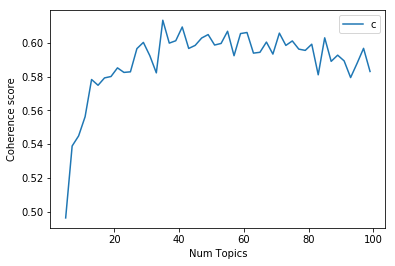

In [35]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# # Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start.value, limit=limit.value, step=step.value)

# Show graph
limit_=limit.value; start_=start.value; step_=step.value;
x = range(start_, limit_, step_)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

# plt.show()
plt.savefig("./figure/grid_search.pdf", bbox_inches='tight')


In [53]:
# Print the coherence scores
i =0
for m, cv in zip(x, coherence_values):
    print("Index = ",i,"Num Topics =", m, " has Coherence Value of", round(cv, 4))
    i = i+1

Index =  0 Num Topics = 5  has Coherence Value of 0.4962
Index =  1 Num Topics = 7  has Coherence Value of 0.5389
Index =  2 Num Topics = 9  has Coherence Value of 0.5449
Index =  3 Num Topics = 11  has Coherence Value of 0.5563
Index =  4 Num Topics = 13  has Coherence Value of 0.5783
Index =  5 Num Topics = 15  has Coherence Value of 0.5749
Index =  6 Num Topics = 17  has Coherence Value of 0.5793
Index =  7 Num Topics = 19  has Coherence Value of 0.5801
Index =  8 Num Topics = 21  has Coherence Value of 0.5852
Index =  9 Num Topics = 23  has Coherence Value of 0.5825
Index =  10 Num Topics = 25  has Coherence Value of 0.5829
Index =  11 Num Topics = 27  has Coherence Value of 0.5966
Index =  12 Num Topics = 29  has Coherence Value of 0.6003
Index =  13 Num Topics = 31  has Coherence Value of 0.5924
Index =  14 Num Topics = 33  has Coherence Value of 0.5823
Index =  15 Num Topics = 35  has Coherence Value of 0.6135
Index =  16 Num Topics = 37  has Coherence Value of 0.5999
Index =  1

Here we choose 41 as the optimal topic number.

>TAKE CARE: the topic number will be used for all part below.

In [56]:
#Set parameter
print("topic_num:")
topic_num = widgets.IntText(41)
display(topic_num)

topic_num:


IntText(value=41)

Here we train the model for 5 times with optimal topic number and choose the best one.

In [57]:
model_list_LDA = []
for i in range(5):
    model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=topic_num.value, id2word=id2word)
    c = CoherenceModel(model=model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    model_list_LDA.append((model, c.get_coherence()))
model, tc = max(model_list_LDA, key=lambda x: x[1])
# Save model.
model.save('model_41.ldamodel')
# Load model.
model = gensim.models.wrappers.LdaMallet.load('model_41.ldamodel')


In [58]:
model = gensim.models.wrappers.LdaMallet.load('model_41.ldamodel')

# Select the model and print the topics
optimal_model = model#model_list[int((topic_num.value - start.value)/step.value)]
optimal_topic_num = topic_num.value
model_topics = optimal_model.show_topics(formatted=False)
# pprint(optimal_model.print_topics(num_words=10))

from collections import Counter
import matplotlib.colors as mcolors

topics = optimal_model.show_topics(num_topics=optimal_topic_num, formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

def concat(batch):
    return [w for w in batch.word]
df_topic_word = pd.DataFrame(df.groupby('topic_id').apply(concat))
df_topic_word.columns = ['words']
df_topic_word

,words
topic_id,
0,"[human, trial, target, subject, response, decision, behavior, stimulus, category, cue]"
1,"[regret, game, player, strategy, online, arm, round, bandit, action, play]"
2,"[rule, domain, causal, probabilistic, program, inference, knowledge, relation, concept, formula]"
3,"[inference, likelihood, posterior, bayesian, latent, variational, conditional, generative, probabilistic, latent_variable]"
4,"[cluster, partition, clustering, center, similarity, distance, cut, assign, spectral_cluster, mixture]"
5,"[ai, pi, wi, curve, generalization, si, li, calculate, coefficient, basis]"
6,"[dynamic, continuous, stable, energy, stability, perturbation, stochastic, converge, phase, nonlinear]"
7,"[search, selection, greedy, objective, score, heuristic, submodular, maximize, optimize, evaluation]"
8,"[neuron, response, stimulus, spike, correlation, population, spike_train, poisson, ms, firing_rate]"


However, I find topics is hard to label although the sorce is high. And I tried 20 topics model as below:

In [61]:
ldamallet.save('model_20.ldamodel')
model = gensim.models.wrappers.LdaMallet.load('model_20.ldamodel')

# Select the model and print the topics
optimal_model = model#model_list[int((topic_num.value - start.value)/step.value)]
optimal_topic_num = topic_num.value
model_topics = optimal_model.show_topics(formatted=False)
# pprint(optimal_model.print_topics(num_words=10))

from collections import Counter
import matplotlib.colors as mcolors

topics = optimal_model.show_topics(num_topics=optimal_topic_num, formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

def concat(batch):
    return [w for w in batch.word]
df_topic_word = pd.DataFrame(df.groupby('topic_id').apply(concat))
df_topic_word.columns = ['words']
df_topic_word

,words
topic_id,
0,"[signal, source, filter, frequency, speech, channel, brain, subject, speaker, ica]"
1,"[rule, neural_network, net, layer, architecture, hide, memory, generalization, activation, hidden_unit]"
2,"[neuron, cell, spike, activity, circuit, synaptic, signal, connection, dynamic, chip]"
3,"[dynamic, trajectory, transition, path, target, position, move, movement, continuous, feedback]"
4,"[object, face, recognition, visual, category, video, match, frame, scene, human]"
5,"[gradient, convex, objective, stochastic, dual, min, smooth, minimization, converge, norm]"
6,"[estimator, density, bias, entropy, regression, finite, asymptotic, risk, continuous, theoretical]"
7,"[layer, deep, architecture, neural_network, convolutional, cnn, preprint, recurrent, gradient, rnn]"
8,"[kernel, distance, metric, manifold, projection, embed, eigenvalue, operator, eigenvector, transformation]"


In [85]:
labels= []
for i in range(20):
    labels.append( 'lable_'+str(i))
df_topic_label = pd.DataFrame(labels)
df_topic_label.columns = ['topic_label']
t = pd.concat([df_topic_label,df_topic_word], axis=1)
t = t[~t.topic_label.str.contains("Unknow")]
t

,topic_label,words
0,lable_0,"[signal, source, filter, frequency, speech, channel, brain, subject, speaker, ica]"
1,lable_1,"[rule, neural_network, net, layer, architecture, hide, memory, generalization, activation, hidden_unit]"
2,lable_2,"[neuron, cell, spike, activity, circuit, synaptic, signal, connection, dynamic, chip]"
3,lable_3,"[dynamic, trajectory, transition, path, target, position, move, movement, continuous, feedback]"
4,lable_4,"[object, face, recognition, visual, category, video, match, frame, scene, human]"
5,lable_5,"[gradient, convex, objective, stochastic, dual, min, smooth, minimization, converge, norm]"
6,lable_6,"[estimator, density, bias, entropy, regression, finite, asymptotic, risk, continuous, theoretical]"
7,lable_7,"[layer, deep, architecture, neural_network, convolutional, cnn, preprint, recurrent, gradient, rnn]"
8,lable_8,"[kernel, distance, metric, manifold, projection, embed, eigenvalue, operator, eigenvector, transformation]"
9,lable_9,"[query, user, rank, item, group, event, individual, score, permutation, greedy]"


In [83]:
# manul_label = pd.DataFrame([(0, 'Sociocultural Context'),(1, 'Unknown0'),(2, 'Unknown1'),(3, 'Embodied Cognition'),(4, 'Epistemological Cognition'),
#               (5, 'Unknown2'),(6, 'Critique and Revision '),(7, 'Feedback'),(8, 'Professional Development'),(9, 'Language Learning'),
#               (10, 'Problem Solving'),(11, 'Scaffolding'),(12, 'Eye-tracking and Gaze'),(13, 'Maker'),(14, 'Coding'),
#               (15, 'Learning Environments'),(16, 'Museum'),(17, 'Knowledge Building'),(18, 'Complex Systems'),(19, 'Unknown3'),
#               (20, 'Online Course'),(21, 'Conceptual Learning'),(22, 'Metacognition'),(23, 'Leadership'),(24, 'Expertise'),
#               (25, 'Identity and Equity'),(26, 'Mathematic'),(27, 'Software'),(28, 'Workshop and Robot'),(29, 'Games and Gaming'),])
# manul_label = pd.DataFrame(l)
# manul_label.columns = ['topic_num', 'topic_label']
# df_topic_label.topic_label = manul_label.topic_label
# df_topic_label


### 3.1 Finding the dominant topic in each paper
One of the practical application of topic modeling is to determine what topic a given document is about. Based on the vector of a document, we take the first, the one takes largest proportion in doc, as its dominant topic. Also, we add each documents' dominant topic contribution(proportion) and label to dataframe. In the last part, the labels of paper will be used for cluster.

In [116]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=contents):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
#         print(i)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

# optimal_model = gensim.models.wrappers.LdaMallet('./mallet/bin/mallet', corpus=corpus, num_topics=20, id2word=id2word)
df_topic_sents_keywords = format_topics_sentences(ldamodel=gensim.models.wrappers.LdaMallet('./mallet/bin/mallet', corpus=corpus, num_topics=20, id2word=id2word), corpus=corpus, texts=contents)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic = df_dominant_topic.merge(df_topic_label, left_on='Dominant_Topic', right_index=True).sort_values(by = 'Document_No')
# Show
pd.set_option('display.max_colwidth', 50)
df_dominant_topic.head(10)

FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/wz/sd7gzpn939vbqwkvk0v78dfh0000gn/T/b1232a_doctopics.txt.infer'

In [117]:
gensim.models.wrappers.LdaMallet('./mallet/bin/mallet', corpus=corpus, num_topics=20, id2word=id2word)[corpus]

[[(0, 0.014098107377365778),
  (1, 0.09508175614780481),
  (2, 0.004184369769537788),
  (3, 0.1388567014291232),
  (4, 0.009334363332045835),
  (5, 0.009849362688296639),
  (6, 0.03173683532895584),
  (7, 0.04371057036178705),
  (8, 0.00869061413673233),
  (9, 0.10589674262907171),
  (10, 0.07834427706965366),
  (11, 0.007531865585168019),
  (12, 0.014098107377365778),
  (13, 0.021823097721127848),
  (14, 0.15713917857602677),
  (15, 0.0829792712759109),
  (16, 0.04744431569460538),
  (17, 0.00663061671172911),
  (18, 0.012295609630487961),
  (19, 0.11027423715720355)],
 [(0, 0.006071190951430473),
  (1, 0.007900864936793083),
  (2, 0.01056220891550233),
  (3, 0.052644710578842326),
  (4, 0.005738522954091817),
  (5, 0.006237524950099801),
  (6, 0.009231536926147706),
  (7, 0.006071190951430473),
  (8, 0.008233532934131739),
  (9, 0.19702262142381904),
  (10, 0.010229540918163674),
  (11, 0.026862940785096476),
  (12, 0.0047405189620758495),
  (13, 0.45284431137724557),
  (14, 0.007734

In [115]:
# format_topics_sentences(ldamodel=gensim.models.wrappers.LdaMallet.load('model_20.ldamodel'), corpus=corpus, texts = contents)
t =gensim.models.wrappers.LdaMallet.load('model_20.ldamodel')
t.show_topic(2)

[('neuron', 0.06397144418311833),
 ('cell', 0.026432542227923884),
 ('spike', 0.021529708027463),
 ('activity', 0.014393723421946641),
 ('circuit', 0.013909676193191266),
 ('synaptic', 0.010239232176371368),
 ('signal', 0.008617822440785879),
 ('connection', 0.00860891359608486),
 ('dynamic', 0.0076794241322785265),
 ('chip', 0.007581426840567315)]

Using TSNE to visulize topic

In [ ]:
from sklearn.manifold import TSNE
hm = np.array([[y for (x,y) in model[corpus[i]]] for i in range(len(corpus))])
tsne = TSNE(random_state=2017, perplexity=30, early_exaggeration=120)
embedding = tsne.fit_transform(hm)
embedding = pd.DataFrame(embedding, columns=['x','y'])
embedding['hue'] = hm.argmax(axis=1)

In [ ]:
source = ColumnDataSource(
        data=dict(
            x = embedding.x,
            y = embedding.y,
            colors = [all_palettes['Set1'][8][i] for i in embedding.hue],
            title = df.title,
            year = df.year,
            alpha = [0.9] * embedding.shape[0],
            size = [7] * embedding.shape[0]
        )
    )
hover_tsne = HoverTool(names=["df"], tooltips="""
    <div style="margin: 10">
        <div style="margin: 0 auto; width:300px;">
            <span style="font-size: 12px; font-weight: bold;">Title:</span>
            <span style="font-size: 12px">@title</span>
            <span style="font-size: 12px; font-weight: bold;">Year:</span>
            <span style="font-size: 12px">@year</span>
        </div>
    </div>
    """)
tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset']
plot_tsne = figure(plot_width=700, plot_height=700, tools=tools_tsne, title='Papers')
plot_tsne.circle('x', 'y', size='size', fill_color='colors', 
                 alpha='alpha', line_alpha=0, line_width=0.01, source=source, name="df")

callback = CustomJS(args=dict(source=source), code=
    """
    var data = source.data;
    var f = cb_obj.value
    x = data['x']
    y = data['y']
    colors = data['colors']
    alpha = data['alpha']
    title = data['title']
    year = data['year']
    size = data['size']
    for (i = 0; i < x.length; i++) {
        if (year[i] <= f) {
            alpha[i] = 0.9
            size[i] = 7
        } else {
              alpha[i] = 0.05
            size[i] = 4
        }
    }
    source.change.emit();
    """)

slider = Slider(start=df.year.min(), end=df.year.max(), value=2016, step=1, title="Before year")
slider.js_on_change('value', callback)

layout = column(slider, plot_tsne)
show(layout)
